In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import yaml
import os
import glob

In [26]:
CONFIG_PATH = "/home/office5/ATE/Ketan_sir/"
def load_config(config_name):
    with open(os.path.join(CONFIG_PATH, config_name)) as file:
        config = yaml.safe_load(file)
    return config

config = load_config("config.yaml")
config

{'l_thresh': 40,
 'u_thresh': 200,
 't_lower': 100,
 't_upper': 200,
 'L2Gradient': True,
 'connectivity': 4,
 'get_pixel_img1': 5,
 'get_pixel_img2': 10,
 'get_kernel_size_value': 1,
 'debug': False,
 'y_size': 200,
 'x_size': 500}

In [27]:
def show(img):
    plt.figure(figsize = (15,12))
    plt.imshow(img)
    plt.show()

In [28]:
def get_edge_image(img1):
    thresh = cv2.threshold(img1,config['l_thresh'],config['u_thresh'],cv2.THRESH_BINARY)[1]
    edge = cv2.Canny(thresh, config['t_lower'], config['t_upper'], L2gradient = config['L2Gradient'])
    return edge

def get_connected_comp_img(edge):
    lst_component = []
    output = cv2.connectedComponentsWithStats(edge, config['connectivity'], cv2.CV_32S)
    (numLabels, labels, stats, centroids) = output

    # loop over the number of unique connected component labels
    for i in range(0, numLabels):
        if i == 0:
            text = "examining component {}/{} (background)".format(
                i + 1, numLabels)
        # otherwise, we are examining an actual connected component
        else:
            text = "examining component {}/{}".format( i + 1, numLabels)
        # x_ = stats[i, cv2.CC_STAT_LEFT]
        # y_ = stats[i, cv2.CC_STAT_TOP]
        w_ = stats[i, cv2.CC_STAT_WIDTH]
        h_ = stats[i, cv2.CC_STAT_HEIGHT]
        area = stats[i, cv2.CC_STAT_AREA]
        (cX, cY) = centroids[i]

        keepWidth = w_ > 2
        keepHeight = h_ > 2
        keepArea = area > 50

        if all((keepWidth, keepHeight, keepArea)):
            componentMask = (labels == i).astype("uint8") * 255
            # print(componentMask)
            # cv2.imwrite(f"/home/office5/Image_Code/Ketan_sir/try1_fun_component/{i}.png",componentMask)
            color_img  = cv2.cvtColor(componentMask,cv2.COLOR_GRAY2BGR)
            lst_component.append(color_img)
    return lst_component

In [29]:
def get_extreme_point(all_component_image):

    # to store all extreme point
    extr_point = []

    # Here define range from 1 to n because 0 image is backgroumd
    for i in range(1,len(all_component_image)):
        gray = cv2.cvtColor(all_component_image[i],cv2.COLOR_BGR2GRAY)
        coords = np.column_stack(np.where(gray == 255))

        # print(coords)
        a = np.min(coords,axis=0)
        b = np.max(coords,axis=0)

        y_min,x_min,y_max,x_max = a[0],a[1],b[0],b[1]

        points = []

        # for i in range(len(coords)):
        #     if(y_min == coords[i][0]):
        #         pass
        #     else:
        #         points.append([coords[i-1][0], coords[i-1][1]]) 
        #         break
            
        for i in range(len(coords)):
            if(x_min == coords[i][1]):
                points.append([coords[i][0], coords[i][1]]) 
                break
            else:
                pass
        points.append([coords[-1][0] , coords[-1][1]])
        points = np.array(points)

        for i in range(2):
            extr_point.append([points[i][0], points[i][1]])

    return extr_point
        


In [30]:
def get_index_kernel(ori_gray, extreme_point_arr, set_kernel_value):

    y1_s = extreme_point_arr[0] - config['get_kernel_size_value']
    y2_s = extreme_point_arr[0] + config['get_kernel_size_value']
    x1_s = extreme_point_arr[1] - config['get_kernel_size_value']
    x2_s = extreme_point_arr[1] + config['get_kernel_size_value']

    try:
        kernel_value =  ori_gray[y1_s:y2_s + 1,x1_s:x2_s + 1]
        
        for i in range(len(kernel_value[0])):
            for j in range(len(kernel_value[1])):
                set_kernel_value[i][j] = (np.subtract(int(kernel_value[config['get_kernel_size_value']][config['get_kernel_size_value']]),int(kernel_value[i][j])))
                set_kernel_value[config['get_kernel_size_value']][config['get_kernel_size_value']] = 5 
                if(set_kernel_value[i][j]==0):
                    set_kernel_value[i][j] = 1
                elif(set_kernel_value[i][j]<0):
                    set_kernel_value[i][j] = 0
                else:
                    set_kernel_value[i][j] = 1
    except:
        set_kernel_value = np.zeros((3,3))
    return set_kernel_value

In [31]:
def get_removed_extreme_point(ori_gray, all_extreme_point):

    extreme_point_list = []
    dict1 = {}
    kernel_shape = (config['get_kernel_size_value'] * 2) + 1 ## 1->3 2->5 3->7 kerenl_size
    m = 0
    dict1 = {}
    for i in range(len(all_extreme_point)):
        extreme_point_arr = np.array(all_extreme_point[i])
        zero_kernel_arr = np.zeros((kernel_shape,kernel_shape))
        kernel_value = get_index_kernel(ori_gray,extreme_point_arr,zero_kernel_arr)
        unique_1_0 = np.unique(kernel_value,return_counts=True)
        # print("unique_1_0",unique_1_0)
        if len(unique_1_0[0])==3:
            count_0 = unique_1_0[1][0]
            count_1 = unique_1_0[1][1]
            # print(count_0,count_1)
            dict1['0'] = count_0
            dict1['1'] = count_1
            if (count_0==3 and count_1==5) or (count_0==5 and count_1==3):
                temp_kernel_size_value = config['get_kernel_size_value']
                corner_1 = kernel_value[0][0]
                corner_2 = kernel_value[0][kernel_shape-1]
                corner_3 = kernel_value[kernel_shape-1][0]
                corner_4 = kernel_value[kernel_shape-1][kernel_shape-1]
                try:
                    corner_point = np.array([corner_1,corner_2,corner_3,corner_4])
                    for key, value in dict1.items():
                        if value == 3:
                            corner_index = np.where(corner_point==int(key)) 
                            # print("corner_index",corner_index)

                            if corner_index[0][0] == 0:
                                x,y = 0,0
                                if (kernel_value[x][y]==int(key) and kernel_value[x+1][y]==int(key) and kernel_value[x][y+1]==int(key)):
                                    extreme_point_list.append([all_extreme_point[i][0],all_extreme_point[i][1]])

                            if corner_index[0][0] == 1:
                                x,y = 0,kernel_shape-1
                                if (kernel_value[x][y]==int(key) and kernel_value[x][y-1]==int(key) and kernel_value[x+1][y]==int(key)):
                                    extreme_point_list.append([all_extreme_point[i][0],all_extreme_point[i][1]])

                            if corner_index[0][0] == 2:
                                x,y = kernel_shape-1,0
                                if (kernel_value[x][y]==int(key) and kernel_value[x-1][y]==int(key) and kernel_value[x][y+1]==int(key)):
                                    extreme_point_list.append([all_extreme_point[i][0],all_extreme_point[i][1]])

                            if corner_index[0][0] == 3:
                                x,y = kernel_shape-1,kernel_shape-1
                                if (kernel_value[x][y]==int(key) and kernel_value[x][y-1]==int(key) and kernel_value[x-1][y]==int(key)):
                                    extreme_point_list.append([all_extreme_point[i][0],all_extreme_point[i][1]])
                except:
                    pass

    return extreme_point_list

### 2nd function
making function to get point from original_image, defective image

In [32]:
def get_point_on_image(first_img_point,img1_gray_pth,img2_gray_pth,debug=False):

    gray_img1 = img1_gray_pth
    gray_img2 = img2_gray_pth

    second_img_point = []
    
    for i in range(len(first_img_point)):
        ori_img_loc_y = first_img_point[i][0]
        ori_img_loc_x = first_img_point[i][1]
        x1_f = ori_img_loc_x - config['get_pixel_img1']
        x2_f = ori_img_loc_x + config['get_pixel_img1']
        y1_f = ori_img_loc_y - config['get_pixel_img1']
        y2_f = ori_img_loc_y + config['get_pixel_img1']

        img_crop1  = gray_img1[y1_f:y2_f,x1_f:x2_f]
        img_first = img_crop1.astype(np.int8)

        x1_s = ori_img_loc_x - config['get_pixel_img2']
        x2_s = ori_img_loc_x + config['get_pixel_img2']
        y1_s = ori_img_loc_y - config['get_pixel_img2']
        y2_s = ori_img_loc_y + config['get_pixel_img2']

        img_crop2  = gray_img2[y1_s:y2_s,x1_s:x2_s]
        img_snd = img_crop2.astype(np.int8)
        try:
            dict1 = {}
            for i in range(config['get_pixel_img2']):
                for j in range(config['get_pixel_img2']):
                    dict1[i,j] = np.mean(np.abs(img_first  - img_snd[i:i+config['get_pixel_img2'],j:j+config['get_pixel_img2']]))
            i,j = min(dict1, key=dict1.get)

            s_img_extr_point_x = x1_s + config['get_pixel_img2'] - config['get_pixel_img1'] + j # 10 for each block of first image and -5 for adding from width and height of first image
            s_img_extr_point_y =y1_s + config['get_pixel_img2'] - config['get_pixel_img1'] + i
            second_img_point.append([s_img_extr_point_y,s_img_extr_point_x])
        except:
            pass
        
    if debug:
        print("in debug")
        for i in range(len(first_img_point)):
            gray_img1[first_img_point[i][0]][first_img_point[i][1]] = 255

        for i in range(len(second_img_point)):
            gray_img2[second_img_point[i][0]][second_img_point[i][1]] = 255
        
        # cv2.imwrite('3.png',gray_img2)
        return second_img_point,gray_img1,gray_img2
    else:
        return second_img_point


## Make four images from original and defective images

In [33]:
def get_four_image(original_img,defective_img):
    height , width = original_img.shape
    half_hei, half_wid = height // 2 , width //2
    
    ## for first image 
    img1_centre_y, img1_centre_x = (half_hei) // 2, (half_wid) // 2
    img1_y1, img1_y2, img1_x1, img1_x2 = (img1_centre_y - config['y_size']) , (img1_centre_y + config['y_size']) , (img1_centre_x - config['x_size']) , (img1_centre_x + config['x_size']) 

    ## for second image 
    img2_centre_y, img2_centre_x = (half_hei) // 2, (half_wid + width) // 2
    img2_y1, img2_y2, img2_x1, img2_x2 = (img2_centre_y - config['y_size']) , (img2_centre_y + config['y_size']) , (img2_centre_x - config['x_size']) , (img2_centre_x + config['x_size']) 

    ## for third image 
    img3_centre_y, img3_centre_x = (half_hei + height) // 2, (half_wid) // 2
    img3_y1, img3_y2, img3_x1, img3_x2 = (img3_centre_y - config['y_size']) , (img3_centre_y + config['y_size']) , (img3_centre_x - config['x_size']) , (img3_centre_x + config['x_size']) 

    ## for fourth image 
    img4_centre_y, img4_centre_x =  (half_hei + height) // 2, (half_wid + width) // 2
    img4_y1, img4_y2, img4_x1, img4_x2 = (img4_centre_y - config['y_size']) , (img4_centre_y + config['y_size']) , (img4_centre_x - config['x_size']) , (img4_centre_x + config['x_size']) 

    ori_img1 = original_img[img1_y1:img1_y2, img1_x1:img1_x2]
    ori_img2 = original_img[img2_y1:img2_y2, img2_x1:img2_x2]
    ori_img3 = original_img[img3_y1:img3_y2, img3_x1:img3_x2]
    ori_img4 = original_img[img4_y1:img4_y2, img4_x1:img4_x2]

    defective_img1 = defective_img[img1_y1:img1_y2, img1_x1:img1_x2]
    defective_img2 = defective_img[img2_y1:img2_y2, img2_x1:img2_x2]
    defective_img3 = defective_img[img3_y1:img3_y2, img3_x1:img3_x2]
    defective_img4 = defective_img[img4_y1:img4_y2, img4_x1:img4_x2]

    img1_pixel_val = (img1_y1,img1_x1)
    img2_pixel_val = (img2_y1,img2_x1)
    img3_pixel_val = (img3_y1,img3_x1)
    img4_pixel_val = (img4_y1,img4_x1)

    return (ori_img1, ori_img2, ori_img3, ori_img4) , (defective_img1,defective_img2,defective_img3,defective_img4) , (img1_pixel_val,img2_pixel_val,img3_pixel_val,img4_pixel_val)


### Final_call function

In [34]:
def get_point_for_both_img(gray_img1,gray_img2,debug):

    ### first function part
    edge = get_edge_image(gray_img1)
    all_component_image = get_connected_comp_img(edge)
    all_extreme_point =  get_extreme_point(all_component_image)
    remove_duplicate_extreme_point = [tuple(row) for row in all_extreme_point]
    remove_duplicate_extreme_point = np.unique(remove_duplicate_extreme_point,axis=0)
    first_img_extreme_point = get_removed_extreme_point(gray_img1,remove_duplicate_extreme_point)

    

    ## second function part
    if debug:
        second_img_extreme_point,original_img,defect_img = get_point_on_image(first_img_extreme_point,gray_img1,gray_img2,debug)
        return first_img_extreme_point,second_img_extreme_point,original_img,defect_img
    else:
        second_img_extreme_point = get_point_on_image(first_img_extreme_point,gray_img1,gray_img2,debug)
        return first_img_extreme_point,second_img_extreme_point

In [35]:
def main(original_img,defective_img):
    # get four part image of each original and defective image
    original_four_img, defective_four_img , four_image_points =  get_four_image(original_img,defective_img)

    # for collecting original point from image
    original_final_point_for_all_images = []
    defect_final_point_for_all_images = []

    m=0
    for gray_img1, gray_img2, img_pixel_point in zip(original_four_img, defective_four_img, four_image_points):

        m+=1
        ## If debug is true then it will also return images with extreme point drawn on it
        if config['debug']:
            first_img_extreme_point,second_img_extreme_point,original_img,defect_img = get_point_for_both_img(gray_img1,gray_img2,config['debug'])

            cv2.imwrite(f'/home/office5/ATE/Ketan_sir/testing_images/four_img/original_{m}.png',original_img)
            cv2.imwrite(f'/home/office5/ATE/Ketan_sir/testing_images/four_img/defective_{m}.png',defect_img)
        else:
            first_img_extreme_point,second_img_extreme_point = get_point_for_both_img(gray_img1,gray_img2,config['debug'])

        print("m = ",m)
        print("Original_image_point", first_img_extreme_point)
        print("Defective_image_point", second_img_extreme_point)
        # print("first_img_extreme_point",len(first_img_extreme_point))
        # print("second_img_extreme_point",len(second_img_extreme_point))

        for i in range(len(second_img_extreme_point)):
            a = np.array(img_pixel_point)
            # print("a",a)
            original_point = np.array(first_img_extreme_point[i]) + a
            defect_point = np.array(second_img_extreme_point[i]) + a

            original_final_point_for_all_images.append(list(original_point))
            defect_final_point_for_all_images.append(list(defect_point))

    return original_final_point_for_all_images, defect_final_point_for_all_images

In [36]:
# pass here two images input
original_img = cv2.imread('/home/office5/ATE/Data_Images/data/Anna2.bmp',0)
defective_img = cv2.imread('/home/office5/ATE/Data_Images/data/Anna3.bmp',0)

original_point, defect_point = main(original_img,defective_img)

m =  1
Original_image_point [[20, 56], [29, 59], [42, 65], [82, 26], [209, 87], [223, 118], [245, 21], [310, 69]]
Defective_image_point [[18, 56], [30, 58], [40, 66], [80, 25], [208, 87], [223, 119], [245, 22], [311, 70]]
m =  2
Original_image_point [[288, 685], [308, 808], [348, 403], [352, 827], [361, 704]]
Defective_image_point [[288, 685], [309, 808], [350, 403], [354, 827], [362, 704]]
m =  3
Original_image_point [[15, 15], [24, 649], [27, 561], [29, 431], [175, 10], [229, 88], [244, 104], [265, 108], [265, 165], [266, 50], [310, 66]]
Defective_image_point [[17, 16], [26, 650], [29, 561], [31, 431], [178, 9], [230, 88], [245, 105], [266, 109], [265, 165], [266, 50], [309, 66]]
m =  4
Original_image_point [[302, 903], [324, 832], [343, 863], [373, 630], [374, 827], [382, 707]]
Defective_image_point [[301, 903], [323, 832], [342, 863], [372, 630], [372, 827], [381, 708]]


In [35]:
# # pass here two images input
# original_img = cv2.imread('/home/office5/ATE/Data_Images/data/Anna2.bmp',0)
# defective_img = cv2.imread('/home/office5/ATE/Data_Images/data/Anna3.bmp',0)

# ## calling main function and get extreme point
# original_final_point_for_all_images, defect_final_point_for_all_images  = main(original_img,defective_img)

# # exact point from original image
# print("original_final_point_for_all_images",original_final_point_for_all_images)
# print("defect_final_point_for_all_images",defect_final_point_for_all_images)

# # # for drawing original extreme point on original image
# # for i in range(len(original_final_point_for_all_images)):
# #     original_img[original_final_point_for_all_images[i][0]][original_final_point_for_all_images[i][1]] = 255

# # for j in range(len(defect_final_point_for_all_images)):
# #     defective_img[defect_final_point_for_all_images[j][0]][defect_final_point_for_all_images[j][1]] = 255

# # cv2.imwrite('original_img_point.png',original_img)
# # cv2.imwrite('defective_img_point.png',defective_img)

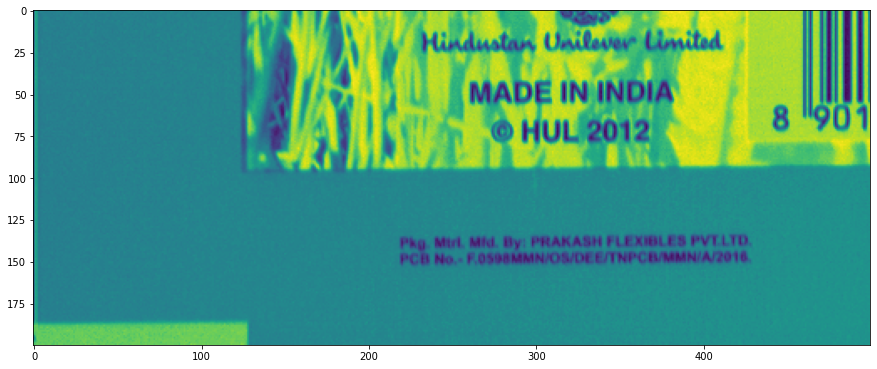

In [60]:
img = cv2.imread('/home/office5/ATE/Data_Images/data/Anna2.bmp',0)
# crop_img = img[500:700, 1000:1500]
show(img[500:700, 1000:1500])
# crop_img


In [ ]:
################################### Testing Images ###############################

# # Load this two image
# original_img = cv2.imread('/home/office5/Image_Code/Ketan_sir/data/Anna2.bmp',0)
# defective_img = cv2.imread('/home/office5/Image_Code/Ketan_sir/data/Anna24.bmp',0)

# # get four part image of each original and defective image
# original_four_img, defective_four_img , four_image_points =  get_four_image(original_img,defective_img)

# # for collecting original point from image
# original_final_point_for_all_images = []
# defect_final_point_for_all_images = []

# m=0
# for gray_img1,gray_img2, img_pixel_point in zip(original_four_img, defective_four_img, four_image_points):
#     m+=1
#     if config['debug']:
#         first_img_point,second_img_point,original_img,defect_img = main(gray_img1,gray_img2,config['debug'])
#     else:
#         first_img_point,second_img_point = main(gray_img1,gray_img2,config['debug'])
    
#     print("Original_image_point", first_img_point)
#     print("Defective_image_point", second_img_point)
#     print("m = ",m)
#     for i in range(len(first_img_point)):
#         a = np.array(img_pixel_point)

#         original_point = np.array(first_img_point[i]) + a
#         defect_point = np.array(second_img_point[i]) + a

#         original_final_point_for_all_images.append(list(original_point))
#         defect_final_point_for_all_images.append(list(defect_point))

# ## exact point from original image
# print("original_final_point_for_all_images",original_final_point_for_all_images)
# print("defect_final_point_for_all_images",defect_final_point_for_all_images)

In [112]:
a = [[51, 24], [57, 65], [66, 25]]
b = [[51, 25], [57, 66], [66, 26]]

In [131]:
c = np.array(a)
d = np.array(b)

for val1,val2 in zip(c,d):
    diff = np.subtract(c,d)
    if list(diff) != [0,0]:
        print(list(val1),list(val2))

[51, 24] [51, 25]
[57, 65] [57, 66]
[66, 25] [66, 26]
